# Differential Private Mechanisms: Building blocks of private learning methods
:label:`dp_mechanisms`

In this notebook we introduce a few basic algorithms for differential privacy. These algorithms, known as "Mechanisms" conventionally, are procedures that are randomized in specific ways to ensure differential privacy. They are the fundamental building blocks of modern DP methods for machine learning.

Throughout the notebook, we will be using the California Housing Dataset and try releasing certain statistics of interest about this dataset under differential privacy. Besides implementing the actual mechanisms, we will also be using a handy open-source tool called ```autodp``` for computing the privacy losses and calibrating parameters of the mechanisms. A dedicated notebook about ```autodp``` and its design will be introduced in a later notebook.


## California Housing Dataset

We will start by loading a dataset:  California housing dataset.  The dataset was derived from the 1990 US Census and often used by sklearn as a toy-scale example.  Here are some characteristics of the datasets.

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).


In [1]:
import sklearn.datasets
import numpy as np

dataset = sklearn.datasets.fetch_california_housing()

print('This is a regression dataset.')
print('Features are: ', dataset.feature_names)
print('The label is: ', dataset.target_names)

This is a regression dataset.
Features are:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
The label is:  ['MedHouseVal']


In [2]:
# Let's extract the relevant information from the sklearn dataset object
X = dataset.data
y = dataset.target
dim = X.shape[1]
n = X.shape[0]

## Queries and their sensitivity
Now we have a dataset, we can talk about what kind of information that we would like to see from the dataset.  A function that takes the the dataset and returns an output (often a vector of numerical numbers but not always) is called a *query*. Let's see a few examples.

> **Example 1:**  Number of Block Groups with MedInc greater than 50,000.

> **Example 2:**  Average Housevalue (over Block Groups).

> **Example 3:**  Median House Age of Block Group 42.

Let's implement them.

In [3]:
data = (X,y)
def query1(data):
    return np.sum(data[0][:,0]>5)

def query2(data):
    return np.mean(data[1])

def query3(data):
    return data[0][42,1]

print((query1(data), query2(data), query3(data)))

(4489, 2.068558169089147, 49.0)


These queries are not quite the same. Example 1 and 2 are considered less sensitive, because they are aggregate statistics of many block groups. Example 3, however, is about a specific Block Group, thus is more likely to reveal sensitive information.  In order to differentially privately answer the above queries, we need to  handle each query differently. A key concept of interest is the **Sensitivity of a Query**

> **Definition** (Global Sensitivity of a Query $f$): The (global) sensitivity of query $f: \text{DataSpace} \rightarrow \mathbb{R}^d$ under norm $\|\cdot\|$ is defined as
$$\Delta_{\|\cdot\|}(f) = \max_{D,D'\text{ neighbors}} \|f(D) - f(D')\|.$$

Consider the Add/Remove neighboring relationship,  it is easy to see that the query in Example 1 has a global sensitivity of $1$ because adding or removing any block groups only changes the number by at most $1$. This family of queries is known as *counting queries*.

For the average query in Example 2, under the "Replace One" neighboring relationship, the query has a senstivitiy of $\text{Max House Value} / n$ where $\text{Max House Value}$ is a known constant for which no houses in the entire universe could exceed and $n$ is the number of block groups.   (Exercise:  What if we want the "Add/Remove" neighboring relationship for the average query).

For the query in Example 3, the value of the 42nd data point can be $|\text{MaxAge} - \text{MinAge}|$, i.e., as large as the output space. 

The natural idea to achieve differential privacy is by adding noise to the query output with the scale of the noise proportional to the sensitivity so it blurs the output sufficiently such that the contribution from a single data point is hidden.  This family of mechanisms is known as the output perturbation mechanisms, or noise-adding mechanisms.  




## Laplace Mechanism: Releasing low-sensitivity queries with pure-DP

The most popular mechanism for releasing pure-DP is 
> **Theorem (Laplace Mechanism)**  The mechanism $\mathcal{M}(f,\text{Data}) = f(\text{Data}) + \mathrm{Lap}(\Delta(f)/\epsilon )$ satisfies $\epsilon$-differential privacy.

There is a multivariate version of the Laplace mechanism too. It adds i.i.d. laplace noise $\mathrm{Lap}(\Delta_1(f)/\epsilon)$ to every coordinate of $f(\text{Data})$ where $\Delta_1(f)$, called the L1-Sensitivity, is a short hand for $\Delta_{\|\cdot\|_1})(f):=\max_{D,D'\text{ neighbors}} \|f(D) - f(D')\|_1$.

The Laplace distribution is also known as the double-sided exponential distribution and the above theorem can be proven by directly bounding the log-density ratio of the two neighboring dataset $\mathcal{M}(f,D)$ and $\mathcal{M}(f,D')$. We leave a formal proof as an exercise but instead, illustrate the two distributions from neighboring datasets by simply plotting them on Query1, where the sensitivity is $1$.

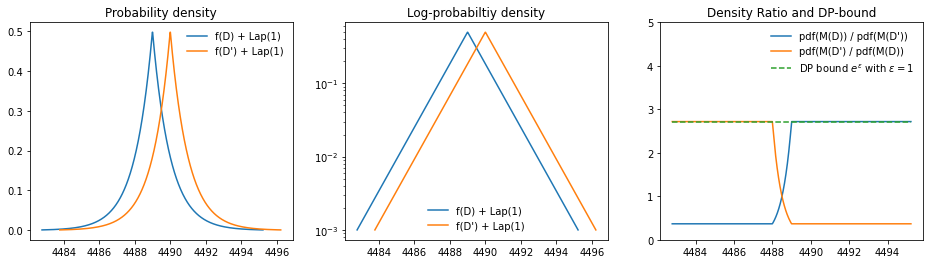

In [4]:
# Illustrate the Laplace distribution
from scipy.stats import laplace
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3,figsize=(16, 4))

ax[0].set_title('Probability density')
ax[1].set_title('Log-probabiltiy density')
ax[2].set_title('Density Ratio and DP-bound')

# Let's plot the probability density of the output of the Laplace mechanism on query1
x = np.linspace(laplace.ppf(0.001),
                laplace.ppf(0.999), 1000)
ax[0].plot(query1(data) + x, laplace.pdf(x),label= 'f(D) + Lap(1)')
ax[0].plot(query1(data)+1 + x,laplace.pdf(x), label = 'f(D\') + Lap(1)')

ax[1].semilogy(query1(data) + x, laplace.pdf(x),label= 'f(D) + Lap(1)')
ax[1].semilogy(query1(data)+1 + x, laplace.pdf(x),label = 'f(D\') + Lap(1)')

ax[2].plot(query1(data) + x, laplace.pdf(x)/laplace.pdf(x+1),label= 'pdf(M(D)) / pdf(M(D\'))') 
ax[2].plot(query1(data) + x, laplace.pdf(x+1)/laplace.pdf(x),label= 'pdf(M(D\') / pdf(M(D))') 
ax[2].plot(query1(data) + x, np.exp(1)*np.ones(shape=(len(x),1)),'--',label=r'DP bound $e^\epsilon$ with $\epsilon=1$')
ax[2].set_ylim((0,5))
ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)
ax[2].legend(loc='best', frameon=False)
plt.show()

As is shown clearly in the figures above, the Laplace mechanism is producing very accurate answers up to $\pm 10$ with high probability. Moreover, the two distributions from neighboring datasets are shifted by a bit but they are still mostly overlapping with each other, thus indistinguishable from one sample.  From the second and third figures above, we can see that the density ratios are bounded by $e^\epsilon$ with $\epsilon=1$.   

Next, let's implement Laplace mechanism and release the three queries.

In [5]:
def LaplaceMech(query,data,sensitivity,eps):
    return query(data) + (1.0*sensitivity/eps)*laplace.rvs()

epsilon= 0.5
a1 = LaplaceMech(query1,data,1.0,epsilon)

# Assuming the max median house value is 10,000,000, i.e., 100 Hundred of thousands.
# Assume ReplaceOne neighbor version of DP
a2 = LaplaceMech(query2,data,100/n,epsilon)

# Assume the max age is 120
a3 = LaplaceMech(query3,data, 120, epsilon)


print('The DP released answers are ',[a1,a2,a3])
print('The true answers are ',[query1(data),query2(data),query3(data)])

The DP released answers are  [4487.259509855552, 2.0977129540981396, 123.54708041982381]
The true answers are  [4489, 2.068558169089147, 49.0]


As is clearly seen, from the examples above, we can accurately release the queries with low-sensitivity relative to the scale of its true answers, as in Query 1 and 2. While the answer for Query 3 is way too noisy for it to be of any use in practice. This is arguably by design, because Query 3 directly asks for information specific to one data point, accuracy of Query 3 is directly at odds with differential privacy. 

## Privacy Computation vs Privacy Calibration
As an detour, we would like to introduce two views of differential privacy accounting.

- Consider a randomized algorithm that adds a fixed amount of Laplace noise a query, one can ask, what is the privacy loss $\epsilon$ incurred by the output of this algorithm. This is called *privacy compution*, or more precisely, *privacy loss computation*. 

- The choice of noise-level (or other parameters) of a randomized algorithm to achieve a prescribed privacy budget $\epsilon$ is called *privacy calibration*. 

For Laplace mechanism, these two are both very simple. But there are cases when *privacy compution* is straightforward, but *privacy calibration* requires numerical computation. There are also cases when there are multiple parametere choices of the randomized algorithm that achieve the same $\epsilon$-DP. In these cases, *privacy calibration* does not have a unique solution. This can quickly become unwieldy when the randomized algorithm is a combination of many building blocks. For this reason, we often use open source tools such as `autodp` for automating these privacy computation and privacy accounting tasks.  

To use it, we need to represent each mechanism we use in `autodp`. The following is an example implementation of Laplace Mechanism in `autodp`.

In [6]:
from autodp.mechanism_zoo import LaplaceMechanism
mech = LaplaceMechanism(b=1.0/epsilon)

# Query for eps given delta
delta1 = 0
eps1 = mech.get_approxDP(delta1)
delta2 = 1e-4
eps2 = mech.get_approxDP(delta2)

print('Mechanism name is \"', mech.name,'\"')
print('Parameters are: ',mech.params)
print('epsilon(delta) = ', eps1, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2, ', at delta = ', delta2)

Mechanism name is " Laplace "
Parameters are:  {'b': 2.0}
epsilon(delta) =  0.5 , at delta =  0
epsilon(delta) =  0.4997999999983336 , at delta =  0.0001


/Users/yuxiangw/miniconda3/envs/d2l/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Besides getting the privacy parameters for $\delta>0$, it can be also used to plot the hypothesis testing interpretation of this mechanism that we learned from the last notebook, which gives a more intuitive explanation of the certified privacy guarantees we are getting.

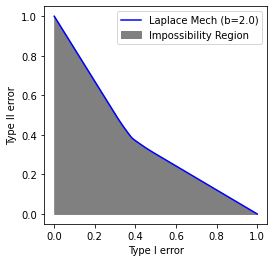

In [7]:
# Get hypothesis testing interpretation so we can directly plot it
fpr_list, fnr_list = mech.plot_fDP()

plt.figure(figsize = (4,4))
plt.plot(fpr_list,fnr_list,color='blue')
plt.fill_between(fpr_list,fnr_list,color='gray')
plt.xlabel('Type I error')
plt.ylabel('Type II error')
plt.legend(['Laplace Mech (b=2.0)','Impossibility Region'])
plt.show()


There are many other convenient aspects of `autodp` that make it very useful as we implement an interative interface for exploratory data analysis with DP or to create more complex algorithms using basic building blocks. This will be covered in the notebook titled *autodp and Modern Privacy Accounting* later in this chapter.

## Gaussian Mechanism: More concentrated noise
A popular alternative to Laplace mechanism is the Gaussian Mechanism which, as its name suggests, adds Gaussian noise instead of Laplace noise to a query.

> **Theorem (Gaussian Mechanism)** Let $\Delta_2(f)$ be the L2 sensitivity of $f$. The mechanism $\mathcal{M}(f,\text{Data}) = f(\text{Data}) + \mathcal{N}\left(0, (\Delta_2(f)\sigma)^2 I\right)$ satisfies $(\epsilon,\delta)$-differential privacy for all $\delta>0$ and $\epsilon(\delta)$ which is an function of $\delta$ parameterized by $\sigma$. One simple upper bound of the function is
$$\epsilon(\delta)\leq \frac{1}{2\sigma^2} + \frac{\sqrt{2\log(1/\delta)}}{\sigma}.$$

The bound above is not tight, but it gives a good illustration of the dependence on various parameters. The exact relationship is more complex, and we can account for it using `autodp` as follows.

In [8]:
from autodp.mechanism_zoo import GaussianMechanism
sigma = 2.0
gm = GaussianMechanism(sigma=sigma)
# Query for eps given delta
delta1 = 1e-6
eps1 = gm.get_approxDP(delta1)
delta2 = 1e-4
eps2 = gm.get_approxDP(delta2)
print('Mechanism name is \"', gm.name,'\"')
print('Parameters are: ',gm.params)
print('epsilon(delta) = ', eps1, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2, ', at delta = ', delta2)

def naive_bound(sigma,delta):
    return 1/2/sigma**2 + np.sqrt(2*np.log(1/delta))/sigma

print('Naive Bound gives epsilon = ', naive_bound(sigma,delta1), ', at delta = ', delta1)
print('Naive Bound gives epsilon = ', naive_bound(sigma,delta2), ', at delta = ', delta2)


Mechanism name is " Gaussian "
Parameters are:  {'sigma': 2.0}
epsilon(delta) =  2.2540846502197396 , at delta =  1e-06
epsilon(delta) =  1.6980725317367789 , at delta =  0.0001
Naive Bound gives epsilon =  2.753260884878466 , at delta =  1e-06
Naive Bound gives epsilon =  2.270966026289347 , at delta =  0.0001


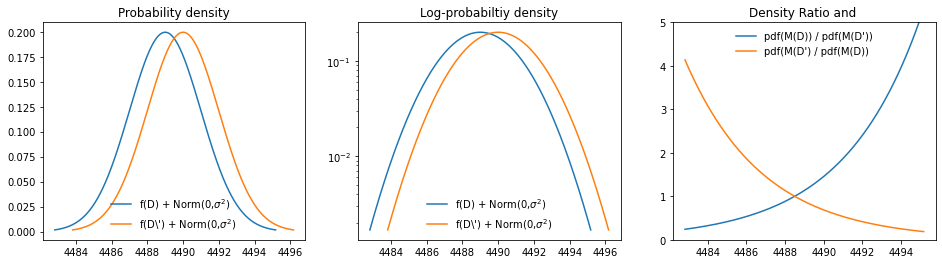

In [9]:
# Illustrate the Gaussian distribution
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3,figsize=(16, 4))

ax[0].set_title('Probability density')
ax[1].set_title('Log-probabiltiy density')
ax[2].set_title('Density Ratio and ')

# Let's plot the probability density of the output of the Laplace mechanism on query1
x = np.linspace(sigma*norm.ppf(0.001),
                sigma*norm.ppf(0.999), 1000)
ax[0].plot(query1(data) + x, norm.pdf(x/sigma)/sigma,label= r'f(D) + Norm(0,$\sigma^2$)')
ax[0].plot(query1(data)+1 + x,norm.pdf(x/sigma)/sigma, label = r'f(D\') + Norm(0,$\sigma^2$)')

ax[1].semilogy(query1(data) + x, norm.pdf(x/sigma)/sigma,label= r'f(D) + Norm(0,$\sigma^2$)')
ax[1].semilogy(query1(data)+1 + x, norm.pdf(x/sigma)/sigma,label = r'f(D\') + Norm(0,$\sigma^2$)')

ax[2].plot(query1(data) + x, norm.pdf(x/sigma)/norm.pdf((x+1)/sigma),label= 'pdf(M(D)) / pdf(M(D\'))') 
ax[2].plot(query1(data) + x, norm.pdf((x+1)/sigma)/norm.pdf(x/sigma),label= 'pdf(M(D\') / pdf(M(D))') 
#ax[2].plot(query1(data) + x, np.exp(1)*np.ones(shape=(len(x),1)),'--',label=r'DP bound $e^\epsilon$ with $\epsilon=1$')
ax[2].set_ylim((0,5))
ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)
ax[2].legend(loc='best', frameon=False)
plt.show()

The Gaussian distribution is more concentrated comparing to the Laplace distribution, thus it gives smaller error when we want a very high confidence.  On the other hand, it is clear from the second and third figures that the log-density ratio gets larger as we more away from the mean, which suggests that Gaussian mechanism does not satisfy pure-differential privacy.   It does satisfy approx-DP with $\delta > 0$ as well as many other nice properties that we have not convered yet.  After all, it is Gaussian so it must be special in one way or another. We will see more of it later.

Now let's implement Gaussian mechanism and apply it to the three queries.

In [10]:
from scipy.stats import norm

def GaussMech(query,data,sensitivity,sigma):
    return query(data) + sensitivity*sigma*norm.rvs()

sigma = 2.0
a1 = GaussMech(query1,data,1.0,sigma)

# Assuming the max median house value is 10,000,000, i.e., 100 Hundred of thousands.
# Assume ReplaceOne neighbor version of DP
a2 = GaussMech(query2,data,100/n,sigma)

# Assume the max age is 120
a3 = GaussMech(query3,data, 120, sigma)


print('The DP released answers are ',[a1,a2,a3])
print('The true answers are ',[query1(data),query2(data),query3(data)])

The DP released answers are  [4488.491202534881, 2.07457897682815, 25.257536255089093]
The true answers are  [4489, 2.068558169089147, 49.0]


The results are similar as in previously with Laplace mechanism. Now let's compare Laplace mechanism and Gaussian mechanism in terms of the adversary's tradeoff function (i.e., ROC curve).

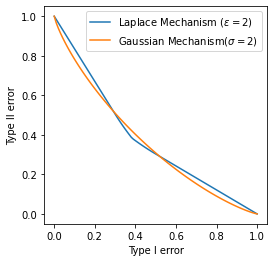

In [11]:
fpr_list, fnr_list = mech.plot_fDP()
fpr_list1, fnr_list1 = gm.plot_fDP()
plt.figure(figsize = (4,4))
plt.plot(fpr_list,fnr_list,label=r'Laplace Mechanism ($\epsilon=2$)')
plt.plot(fpr_list1,fnr_list1,label=r'Gaussian Mechanism($\sigma=2$)')
plt.xlabel('Type I error')
plt.ylabel('Type II error')
plt.legend()
plt.show()


It is clear that one does not dominate the other in terms of the privacy guarantees from the above. A natural question to ask is when to choose Laplace mechanism over Gaussian mechanism and vice versa. Two crude rule-of-thumbs are:

- For release a single statistic, Laplace mechanism is usually prefered for its smaller variance under the same privacy parameter $\epsilon$ (Exercise: how does it depend on $\delta$? Play with `autodp` to find out). 

- The Guassian mechanism will often become the preferred choice when we consider releasing a high dimensional query. 

For example, when we release the sum of $x_1,...,x_n\in \mathbb{R}^d$ satisfying $\|x\|_2\leq 1$ for any $x$ in the universe. Then the L2-sensitivity of $\sum_i x_i$ is $1$ while the L1-sensitivity can be as large as $\sqrt{d}$.  This is when the Gaussian mechanism gives more utility than the Laplace mechanism at a given $(\epsilon,\delta)$-DP.


## Exponential Mechanism: a generic tool for differentially private optimization

So far we have focused on differentially private query release with output perturbation. There are cases when output perturbation is not applicable at all. 

> **Example 1 (Favorite fruit)**: suppose we want to release the favorite fruit  $\in${Apple, Banana, Pear, Orange} among the first thousand of readers of this notebook differentially privately, the query on the dataset be
$$ f(Data) = \underset{v \in \{\text{Apple, Banana, Pear, Orange}\}} {\mathrm{argmax}}\sum_{i=1}^n \mathbf{1}(\text{Reader } i \text{ likes Fruit } v ) $$
will return one of the four fruits.  Adding noise to *Apple* does not quite make sense.

> **Example 2 (Learning Decision Stump)**: Suppose we want to release the most predictive single feature using a thresholding classifier in California Housing data to classify if the median house value is larger than \\$200,000.
The query will return the index of one of the eight features
$$
f(Data) = \underset{v \in \{0,1,2,...,7\}}{\mathrm{argmax}} \max_{\text{Threshold }\tau} \sum_{i=1}^n\mathbf{1}(\text{DecisionStump}_\tau(x_i[v]) = y_i),
$$
where $y_i = \mathbf{1}(\text{BlockGroup $i$'s Median House Value}>\$200,000)$.
Again, we can see that adding noise does not quite make sense here either.

Both examples are optimization problems. They aim at maximizing a data-dependent utility function over a set of possible choices. The generic DP mechanism for solving these optimization problems is known as the *exponential mechanism*.

> **Theorem (Exponential Mechanism)**  Let the utility function $u(\text{Data}, v)$ satisfy that for every fixed $v$,  $u(\text{Data}, v)$ has global-sensitivity $\Delta$, then the mechanism $\mathcal{M}(\text{Data})$ that outputs a sample from the probability distribution  $P(v) \propto e^{ \frac{\epsilon}{2\Delta }u(\text{Data}, v) }$ satisfies $\epsilon$-DP.

The intuition behind exponential mechanism is that we are hoping to make high utility choices exponentially more likely comparing to those with low utility. The proof, which we omit, involes bounding the log-probability ratio  (Hint: don't forget the normalization constants). 

Notice that the sensitivity of a funciton still plays an important role here but it is not the sensitivity of the query, but rather the sensitivity of the utility function. For Example 1, it is clear that the utility function is a counting query, thus it has a sensitivity of $1$.

For Example 2, the sensitivity of the function can be calculated as follows
$$
\begin{aligned}
\left| u(D,v) - u(D',v) \right| &= \left| \max_{\text{Threshold }\tau} \sum_{i=1}^n\mathbf{1}(\text{DecisionStump}_\tau(x_i[v]) = y_i) - \max_{\text{Threshold }\tau} \sum_{i=1}^{n+1}\mathbf{1}(\text{DecisionStump}_\tau(x_i[v]) = y_i)\right| \\
&\leq \max_{\text{Threshold }\tau} \left| \sum_{i=1}^n\mathbf{1}(\text{DecisionStump}_\tau(x_i[v]) = y_i) - \sum_{i=1}^{n+1}\mathbf{1}(\text{DecisionStump}_\tau(x_i[v]) = y_i)\right|\\
&=\max_{\text{Threshold }\tau}  \mathbf{1}(\text{DecisionStump}_\tau(x_{n+1}[v]) = y_{n+1})\\
&\leq 1. 
\end{aligned}
$$
It is left as an exercise to the readers to check that the second inequality is true by discussing the two possibilities: (a) adding the data point does not change the argmax (b) adding the data point changes the argmax.

One can represent exponential mechanism in `autodp` as follows.


In [12]:
# Representing Exponential Mechanism in Autodp

from autodp.mechanism_zoo import ExponentialMechanism
epsilon = 1.0
em = ExponentialMechanism(eps=epsilon)

delta1 = 1e-6
eps1 = em.get_approxDP(delta1)
delta2 = 1e-4
eps2 = em.get_approxDP(delta2)
print('Mechanism name is \"', em.name,'\"')
print('Parameters are: ',em.params)
print('epsilon(delta) = ', eps1, ', at delta = ', delta1)
print('epsilon(delta) = ', eps2, ', at delta = ', delta2)


Mechanism name is " ExpMech "
Parameters are:  {'rho': 0.125, 'xi': 0, 'eps': 1.0}
epsilon(delta) =  0.9999996321204913 , at delta =  1e-06
epsilon(delta) =  0.9999632113791899 , at delta =  0.0001


The implementation of the exponential mechanism can be done by calculating the exponentiated utility function and then sample from a discrete distribution. It can also be implemented by taking the argmax of an iid perturbed noisy utility function, using the well-known Gumbel-Max trick.
> **Fact (Gumbel-Max trick)**  Random variable $V\sim P(v) \propto e^{ U(v)}$ is identically distributed to $\underset{v}{\mathrm{argmax}} U(v) + Z(v)$ where $Z(v)\sim \text{Gumbel}(0,1)$ i.i.d. for each $v$. 

The latter is often prefered as it avoids computing the normalization constant and the randomization can be generated ahead of time.  This gives rise to the following simple implementation of exponential mechanism.

In [13]:
# Now let's implement Exponential mechanism for Finding the Best Feature in a Decision Stump

from sklearn.tree import DecisionTreeClassifier
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

from scipy.stats import gumbel_r

def Accuracy_Decision_Stump(D,v):
    X = D[0][:,v].reshape(-1, 1)
    y = (D[1] > 2) # recall that a unit of 1 is 100,000
    dt_stump.fit(X, y)
    return dt_stump.score(X, y)*len(y)

Choices = range(8)
Utils = [Accuracy_Decision_Stump(data,i) for i in Choices]
print('Utility = ', Utils)
print('The optimal feature is Feature',Choices[np.argmax(Utils)],':', dataset.feature_names[Choices[np.argmax(Utils)]])

def ExpMech(UtilFunc,Data,Choices,Sensitivity, eps):
    def scaledUtilFunc(D,v):
        return 1.0*eps/(2*Sensitivity)*UtilFunc(D,v)
    NoisyUtils = [scaledUtilFunc(Data,v) + gumbel_r.rvs() for v in Choices]
    print('NoisyUtility = ',NoisyUtils) # Note that this should not be part of the private release
    return Choices[np.argmax(NoisyUtils)]

epsilon = 0.1
v = ExpMech(Accuracy_Decision_Stump,data,Choices,1.0, epsilon)
print('Exponential mechanism with eps = 0.1 returns Feature',v, ':',dataset.feature_names[v])

# Even if we want very strong privacy, the answers will still remain correct
epsilon = 0.01
v = ExpMech(Accuracy_Decision_Stump,data,Choices,1.0, epsilon)
print('Exponential mechanism with eps = 0.01 returns Feature',v,':', dataset.feature_names[v])


Utility =  [15717.0, 12312.0, 13476.999999999998, 11930.999999999998, 11930.999999999998, 11930.999999999998, 11930.999999999998, 12924.999999999998]
The optimal feature is Feature 0 : MedInc
NoisyUtility =  [789.578807339984, 615.2901814686188, 673.9592334546138, 596.5051557599903, 599.3263710266845, 595.8603845396391, 596.7244926127779, 648.4306773745553]
Exponential mechanism with eps = 0.1 returns Feature 0 : MedInc
NoisyUtility =  [78.98003930317978, 63.97229342319792, 66.86214253585166, 60.05114797737008, 60.31188557927879, 58.558492054971175, 61.19928721973142, 64.03737682419957]
Exponential mechanism with eps = 0.01 returns Feature 0 : MedInc


## Recap
In this notebook, we learned three basic building blocks of DP mechanisms and worked out concrete examples of how to use them on the California Housing dataset. We had the first taste of `autodp` --- a flexible privacy accounting tool with a very clean API. `autodp` does not concern actual implementations of the randomization procedure, so we learned a "from-scratch" implementation of these mechanisms using `scipy`.  

A cautionary note is that the pseudorandom number generator in `scipy` is often not good enough, so in high-stake deployment of DP mechanisms, it is often required to use more specialized Cryptographically secure pseudorandom number generators instead, e.g., those that are provided by `OpenDP`.

We will learn more basic building blocks of DP in the next notebook.